# Interactive Charts with Google Charting APIs

Cloud Datalab provides functionality to easily use the Google Charting API to produce interactive, JavaScript and SVG-based charts from your data, whether it was loaded from BigQuery, or CSV files or some other source loaded into a vanilla Python list.

These charts can be produced through the `%%chart` command.

## The Chart Command

In [1]:
%%chart --help

usage: %%chart [-h]
               {annotation,area,bars,bubbles,calendar,candlestick,columns,combo,gauge,geo,histogram,line,map,org,paged_table,pie,sankey,scatter,stepped_area,table,timeline,treemap}
               ...

Generate an inline chart using Google Charts using the data in a Table, Query,
dataframe, or list. Numerous types of charts are supported. Options for the
charts can be specified in the cell body using YAML or JSON.

positional arguments:
  {annotation,area,bars,bubbles,calendar,candlestick,columns,combo,gauge,geo,histogram,line,map,org,paged_table,pie,sankey,scatter,stepped_area,table,timeline,treemap}
                        commands
    annotation          Generate a annotation chart.
    area                Generate a area chart.
    bars                Generate a bars chart.
    bubbles             Generate a bubbles chart.
    calendar            Generate a calendar chart.
    candlestick         Generate a candlestick chart.
    columns             Generate a co

As you can see, a variety of chart types are supported.

In [2]:
%%chart line --help

usage: %%chart line [-h] [-f FIELDS] -d DATA

optional arguments:
  -h, --help            show this help message and exit
  -f FIELDS, --fields FIELDS
                        The field(s) to include in the chart
  -d DATA, --data DATA  The name of the variable referencing the Table or
                        Query to chart


The data to be charted is passed in as an argument.

Columns in data must be in a specific order depending on the chart type. The --field argument which takes a comma-separated list of field names allows specifying the ordered set of columns to chart.

Finally, the body of the cell can include additional options to be passed to the chart that are chart-specific.

# Line Chart

In [3]:
%%sql --module timeseries
SELECT timestamp, AVG(latency) AS latency FROM (
  SELECT UTC_USEC_TO_HOUR(timestamp) AS timestamp, latency
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Popular'
)
GROUP BY timestamp
ORDER BY timestamp

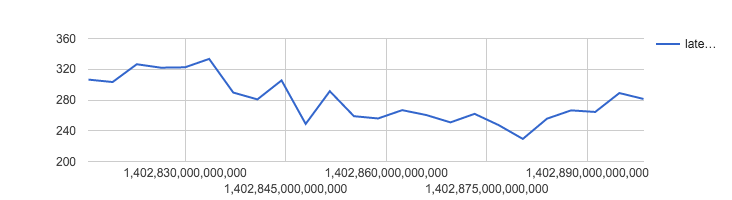

In [4]:
%%chart line --fields timestamp,latency --data timeseries

Bar charts and column charts are similar to line charts.

# Scatter Chart

In [5]:
%%sql --module births
SELECT gestation_weeks AS weeks, weight_pounds AS weight
FROM [publicdata:samples.natality]
WHERE gestation_weeks < 99
LIMIT 1000

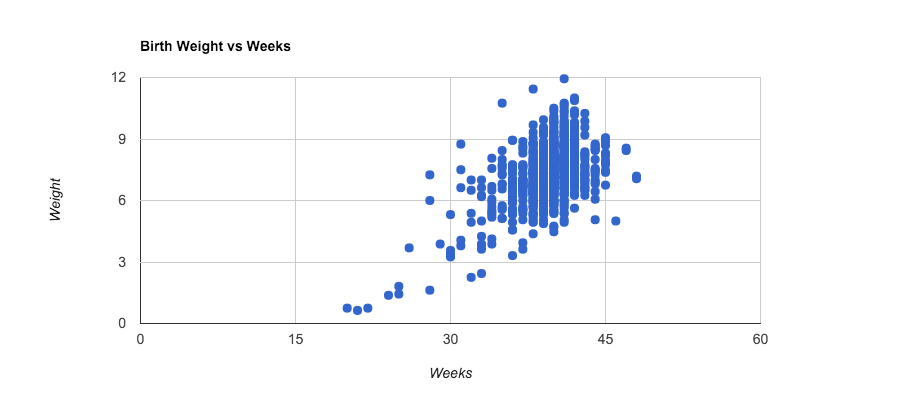

In [6]:
%%chart scatter --data births
title: Birth Weight vs Weeks
height: 400
width: 900
hAxis:
  title: Weeks
vAxis:
  title: Weight
legend: none

# Pie Chart

In [7]:
%%sql --module languages
SELECT repository_language AS language, COUNT(repository_language) as activity
FROM [publicdata:samples.github_timeline]
WHERE type = 'PushEvent'
  AND repository_language != ''
GROUP BY language
ORDER BY activity DESC
LIMIT 10

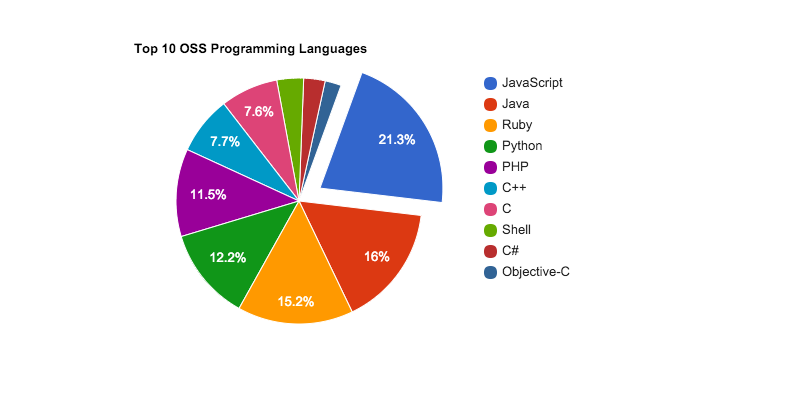

In [8]:
%%chart pie --fields language,activity --data languages
title: Top 10 OSS Programming Languages
height: 400
width: 800
pieStartAngle: 20
slices:
  0:
    offset: .2

# TimeSeries Chart

In [9]:
%%sql --module weather
SELECT max_temperature AS temperature,
       TIMESTAMP(STRING(year) + '-' + STRING(month) + '-' + STRING(day)) AS timestamp
FROM [publicdata:samples.gsod]
WHERE station_number = 727930 AND year >= 2000
ORDER BY year DESC, month DESC, day DESC

In [10]:
%%chart annotation --fields timestamp,temperature --data weather

# Geo Chart

In [11]:
%%sql --module taxi

DEFINE QUERY locations
  SELECT FLOAT(pickup_latitude) AS lat, FLOAT(pickup_longitude) AS lon, medallion
  FROM [833682135931:nyctaxi.trip_data]

DEFINE QUERY geohashes
  SELECT lat, lon,
         CONCAT(STRING(FLOOR(lat*1000+0.5)/1000), ':', STRING(FLOOR(lon*1000+0.5)/1000)) AS geoid,
         medallion
  FROM $locations
  WHERE lat != 0 AND lon != 0

DEFINE QUERY hotspots
  SELECT FIRST(lat) AS lat, FIRST(lon) AS lon, COUNT(medallion) AS pickups
  FROM $geohashes
  WHERE ABS(HASH(medallion)) % 1000 == 1
  GROUP BY geoid
  ORDER BY pickups DESC
  LIMIT 25

In [12]:
%%chart map --fields lat,lon,pickups --data taxi.hotspots
showTip: true
mapType: normal